### LRR-DE Procedure
    In this notebook is implemented the last step of the ion force field parameterization through the LRR-DE procedure
    as the article https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.7b00779

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Ensemble of function
%run ./parse_input.py   
%run ./tool.py    
%run ./distances.py
%run ./multi_objective.py
%run ./testing.py

%matplotlib inline

### Input data

In [2]:
workdir = "./test_data/"

n_test  = 20   # dimension test set
n_train = 100   # dimension training set

index_ion = 1
N_atom    = [385, 97]
N_water   = [128, 32]

old_params = [-1, 0.3770, 0.619232]   # Q, sigma, eps

n_functions = 2  ### 2--> Carica fissa, 3 --> Carica variabile
q_value     = -1 ### if nfunctions = 2 inserire valore della carica

### Parsing of the QM data

In [3]:
os.chdir(workdir)
# Input for 128 water molecules


top128    = parse_input("topology128.txt",     N_atom[0],  'topology')          # Size topology is    3 x N_atom
coo128    = parse_input("coordinates128.txt",  N_atom[0],  'coordinates')       # Size coordinates is N_conf x N_atom x 3
forces128 = parse_input("forces128.txt",       N_atom[0],  'forces')            # Size forces is      N_conf x N_atom x 3
energy128 = parse_input("complexation128.txt", N_atom[0],  'energy')            # Size energy is      N_conf x 2 (raw + corrected)

d_vet128  = distance_ion(coo128,     N_atom[0], index_ion, n_vs = 0)              # Size d_vet is    N_conf x N_atom
d_mat128  = distance_ion_mat(coo128, N_atom[0], index_ion, n_vs = 0)              # Size d_mat is    N_conf x N_atom x 3

# Input for 32 water molecules


top32    = parse_input("topology32.txt",     N_atom[1],  'topology')          # Size topology is    3 x N_atom
coo32    = parse_input("coordinates32.txt",  N_atom[1],  'coordinates')       # Size coordinates is N_conf x N_atom x 3
forces32 = parse_input("forces32.txt",       N_atom[1],  'forces')            # Size forces is      N_conf x N_atom x 3
energy32 = parse_input("complexation32.txt", N_atom[1],  'energy')            # Size energy is      N_conf x 2 (raw + corrected)


d_vet32  = distance_ion(coo32,     N_atom[1], index_ion, n_vs = 0)              # Size d_vet is    N_conf x N_atom
d_mat32  = distance_ion_mat(coo32, N_atom[1], index_ion, n_vs = 0)              # Size d_mat is    N_conf x N_atom x 3

### Model definition

In [4]:
# Data input Energy
e128 = input_setup(N_test = n_test, N_train = n_train, dis_mat = d_mat128, dis_vet = d_vet128, data_type = 'energy', energy = energy128, forces = forces128, topology = top128, 
                   weight = 1, nfunctions   = n_functions, linparams    = [-1, 0, 0], num_linpar   = 3, nlinparams   = [0, 0, 0], num_nlinpar  = 0, q_value = q_value,
                   name = "e128")

# Data input Energy
e32  = input_setup(N_test = n_test, N_train = n_train, dis_mat = d_mat32, dis_vet = d_vet32, data_type = 'energy', energy = energy32, forces = forces32, topology = top32, 
                   weight = 1, nfunctions   = n_functions, linparams    = [-1, 0, 0], num_linpar   = 3, nlinparams   = [0, 0, 0], num_nlinpar  = 0, q_value = q_value,
                   name = "e32")

# Data input Forces
f128 = input_setup(N_test = n_test, N_train = n_train, dis_mat = d_mat128, dis_vet = d_vet128, data_type = 'force', energy = energy128, forces = forces128, topology = top128, 
                   weight = 1, nfunctions   = n_functions, linparams    = [-1, 0, 0], num_linpar   = 3, nlinparams   = [0, 0, 0], num_nlinpar  = 0, q_value = q_value,
                   name = "f128")

# Data input Forces
f32  = input_setup(N_test = n_test, N_train = n_train, dis_mat = d_mat32, dis_vet = d_vet32, data_type = 'force', energy = energy32, forces = forces32, topology = top32, 
                   weight = 1, nfunctions   = n_functions, linparams    = [-1, 0, 0], num_linpar   = 3, nlinparams   = [0, 0, 0], num_nlinpar  = 0, q_value = q_value,
                   name = "f32")

### Training set
e128.eval_energy(flag = "train"), f128.eval_force(flag  = "train"), e32.eval_energy(flag  = "train"), f32.eval_force(flag   = "train")

## Multi Objective
data_set = training_set_MO(e128,e32,f128,f32)
data_set.model_descriptor()
data_set.model = "MO"

## Single Objective
data_set_SO_1 = training_set_SO(f128)
data_set_SO_1.model_descriptor()
data_set_SO_1.model = "SO"


Beware of the right order: e128, e32, f128, f32 


### LRR-DE Evaluation

In [5]:
best, xbest, x, y, N_iter, params = eval_lrrde(data_set)

LOOCV error 89.46377965234265, lambda [[-1.66108705e-13]], Numero Iterazioni 500, Parametri [[0.02149417 0.2271966 ]]


### Testing

SET:  energy # of atoms 385
MSE (test) = 2778.147221760448
MAE (test) = 41.048886142282825
MAE (OLD) = 82.58784523902632

MAE (OLD--TEST) = 92.27288164933678



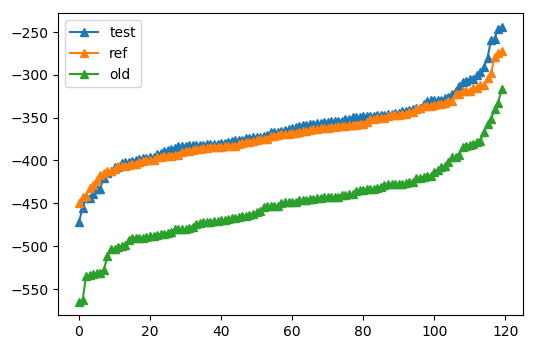

SET:  energy # of atoms 97
MSE (test) = 2169.201713544279
MAE (test) = 36.39149435521494
MAE (OLD) = 87.26489847757756

MAE (OLD--TEST) = 87.7817178945241



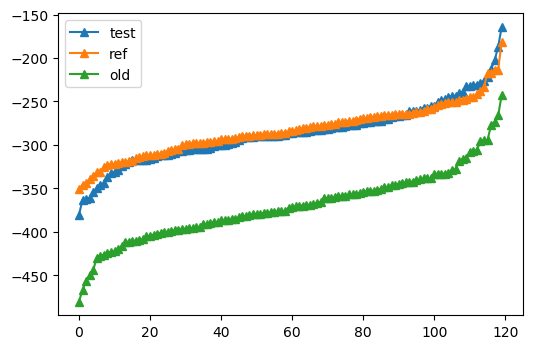

SET:  force # of atoms 385
MSE (test) = 167357.51783882183
MAE (test) = 320.89572152988654
MAE (OLD) = 233.86687811879796

MAE (OLD--TEST) = 277.1283130945617



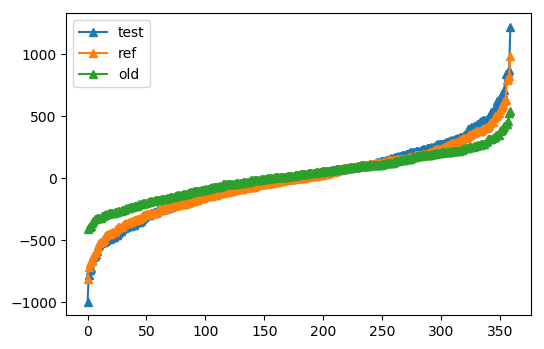

SET:  force # of atoms 97
MSE (test) = 179910.72782435777
MAE (test) = 331.64162395529956
MAE (OLD) = 232.40176404279336

MAE (OLD--TEST) = 291.439088530156



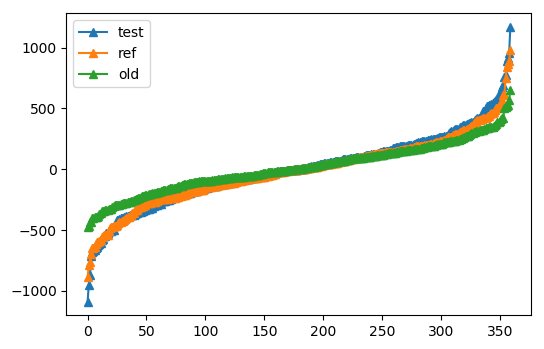

In [6]:
### Test set
data_set.e128.eval_energy(flag = "test"), data_set.f128.eval_force(flag  = "test"), data_set.e32.eval_energy(flag  = "test"), data_set.f32.eval_force(flag   = "test")

testing_data(data_set, params, old_params, plot = 'y')